# Tigre Flood Prediction

In this notebook we present our pipeline using different machine learning models to predict Tigre Tide Alerts.   

Notebook Content:  
1. Modules 
2. Load Data
3. Analyze Data
4. Train and Evaluate Model (Logistic Regression)
5. Other Models Evaluation

## Step 0. Import Dependencies

In [135]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


## Step 1. Load Data

In [145]:
df = pd.read_csv('/Users/axelcasas/Documents/1_Projects/2-data-science/tigre_flood_prediction/data/featurized/tigre_dataset.csv')
df.head()

,Unnamed: 0,date,time,temperature_celsius,weather,humidity,barometer_mbar,visibility,degree,wind_speed_km,wind_direction,alerta_crecida,time_crecida,heigh_m
0,16,2022-01-01,00:00:00,28,Clear,0.55,1004,16.0,100.0,24,East,NO,NaN,NaN
1,17,2022-01-01,01:00:00,28,Clear,0.58,1003,16.0,90.0,17,East,NO,NaN,NaN
2,18,2022-01-01,02:00:00,27,Clear,0.66,1003,16.0,70.0,13,East,NO,NaN,NaN
3,19,2022-01-01,03:00:00,27,Cloudy,0.70,1002,NaN,40.0,13,Northeast,NO,NaN,NaN
4,22,2022-01-01,04:00:00,27,Cloudy,0.70,1001,NaN,20.0,17,North,NO,NaN,NaN


We will make an additional step and encode our data for weather and wind direction using pd.get_dummies()

In [148]:
def clean_and_encode_data():
    
    data = pd.read_csv('/Users/axelcasas/Documents/1_Projects/2-data-science/tigre_flood_prediction/data/featurized/tigre_dataset.csv')
    data = data.drop(columns=['Unnamed: 0', 'visibility', 'time_crecida', 'degree'])
    
    # One-hot encode 'weather' column
    one_hot_encoded_weather = pd.get_dummies(data['weather'])
    data = pd.concat([data, one_hot_encoded_weather], axis=1)
    data.drop(columns=['weather'], inplace=True)
    
    # One-hot encode 'wind_direction' column
    one_hot_encoded_wind = pd.get_dummies(data['wind_direction'], prefix='wind')
    data = pd.concat([data, one_hot_encoded_wind], axis=1)
    data.drop(columns=['wind_direction'], inplace=True)

    # we drop na values in heigh_m (n=6)
    data = data.dropna(subset=['heigh_m'])
    
    return data

df = clean_and_encode_data()
df = df[df['date'] < '2024-03-15']
df = df.sort_values(by=['date','time'])
df.head()

,date,time,temperature_celsius,humidity,barometer_mbar,wind_speed_km,alerta_crecida,heigh_m,Clear,Cloudy,...,Rainy,Thunderstorms,wind_East,wind_North,wind_Northeast,wind_Northwest,wind_South,wind_Southeast,wind_Southwest,wind_West
6,2022-01-01,06:00:00,26,0.79,1004,22,NO,1.37,False,False,...,False,True,False,False,False,True,False,False,False,False
7,2022-01-01,07:00:00,25,0.65,1005,20,NO,1.37,False,True,...,False,False,False,False,False,True,False,False,False,False
8,2022-01-01,08:00:00,24,0.61,1004,17,NO,1.37,False,False,...,False,False,False,False,False,True,False,False,False,False
9,2022-01-01,09:00:00,25,0.54,1005,13,NO,1.37,False,False,...,False,False,False,False,False,False,False,False,False,True
10,2022-01-01,10:00:00,23,0.78,1006,9,NO,1.37,False,False,...,False,False,False,False,False,False,False,False,False,True


In [150]:
# check max date
df.date.max()

'2024-03-14'

## Step 3. Analyze Data

In [151]:
df.shape

(18001, 22)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18001 entries, 6 to 18006
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 18001 non-null  object 
 1   time                 18001 non-null  object 
 2   temperature_celsius  18001 non-null  int64  
 3   humidity             18001 non-null  float64
 4   barometer_mbar       18001 non-null  int64  
 5   wind_speed_km        18001 non-null  int64  
 6   alerta_crecida       18001 non-null  object 
 7   heigh_m              18001 non-null  float64
 8   Clear                18001 non-null  bool   
 9   Cloudy               18001 non-null  bool   
 10  Fog                  18001 non-null  bool   
 11  Light Rain           18001 non-null  bool   
 12  Rainy                18001 non-null  bool   
 13  Thunderstorms        18001 non-null  bool   
 14  wind_East            18001 non-null  bool   
 15  wind_North           18001 non-null  bool

In [153]:
df.isnull().sum()

date                   0
time                   0
temperature_celsius    0
humidity               0
barometer_mbar         0
wind_speed_km          0
alerta_crecida         0
heigh_m                0
Clear                  0
Cloudy                 0
Fog                    0
Light Rain             0
Rainy                  0
Thunderstorms          0
wind_East              0
wind_North             0
wind_Northeast         0
wind_Northwest         0
wind_South             0
wind_Southeast         0
wind_Southwest         0
wind_West              0
dtype: int64

In [154]:
df['alerta_crecida'].value_counts()

alerta_crecida
NO     13758
YES     4243
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Alerta Crecida')

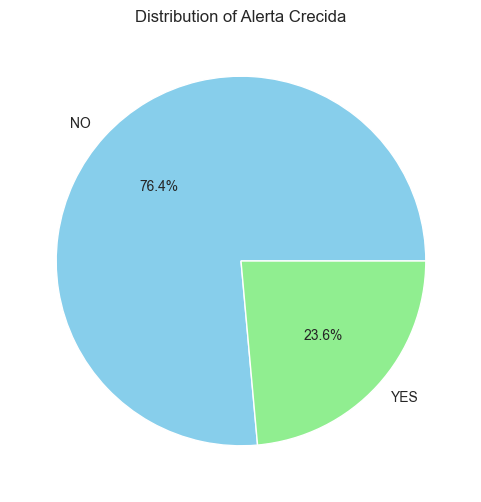

In [155]:
alerta_crecida_counts = df['alerta_crecida'].value_counts()
sns.set_style('whitegrid')
plt.figure(figsize=(6, 6))
plt.pie(alerta_crecida_counts, labels=alerta_crecida_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Alerta Crecida')

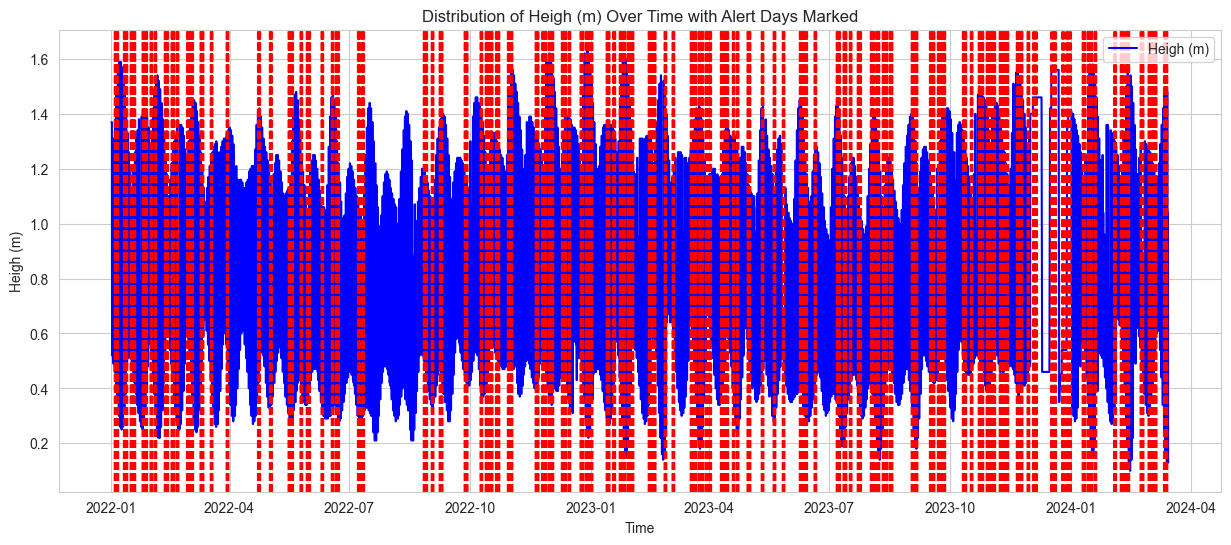

In [156]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df_filtered = df[df['date'] <= '2024-03-15']

# Plot the distribution of heigh_m
plt.figure(figsize=(15, 6))
plt.plot(df_filtered['datetime'], df_filtered['heigh_m'], color='blue', label='Heigh (m)')

# Mark red lines for days where alerta_crecida was 'YES'
for index, row in df_filtered[df_filtered['alerta_crecida'] == 'YES'].iterrows():
    plt.axvline(row['datetime'], color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Heigh (m)')
plt.title('Distribution of Heigh (m) Over Time with Alert Days Marked')
plt.legend()
plt.grid(True)

df = df.drop(columns=['datetime'])

## Step 4. Train and Evaluate Model

As our target/dependent variable is categorical, we will first use a Logistic Regression Model

Train Accuracy: 0.76
Test Accuracy: 0.76
Classification report:  0.762565953901694


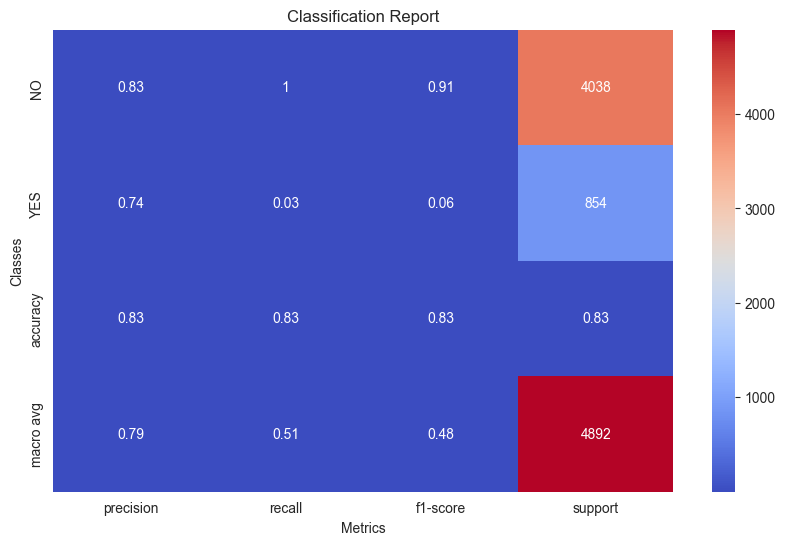

In [157]:
# Select variables
X = df.drop(columns=['date', 'time', 'alerta_crecida'])
y = df['alerta_crecida']

# scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Init and fit
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train).round(2)
test_accuracy = accuracy_score(y_test, y_pred_test).round(2)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print('Classification report: ', accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].round(2), annot=True, cmap='coolwarm', fmt='g')
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()


Let's visualize the results

Classification report:
              precision    recall  f1-score   support

          NO       0.76      1.00      0.87      2746
         YES       1.00      0.00      0.00       855

    accuracy                           0.76      3601
   macro avg       0.88      0.50      0.43      3601
weighted avg       0.82      0.76      0.66      3601



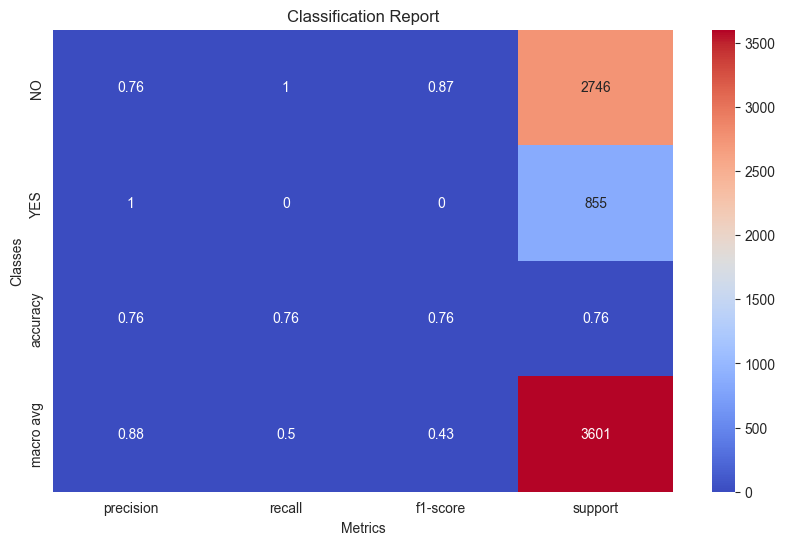

In [158]:
# Print classification report
print('Classification report:')
print(classification_report(y_test, y_pred_test, zero_division=1))

# Convert classification report to dataframe
report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=1)
report_df = pd.DataFrame(report).transpose()

# Plot classification report as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].round(2), annot=True, cmap='coolwarm', fmt='g')
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

## Step 5. Try And Evaluate Other Models

### 1. Random Forest

Random Forest Classifier Accuracy: 0.7123021382949181


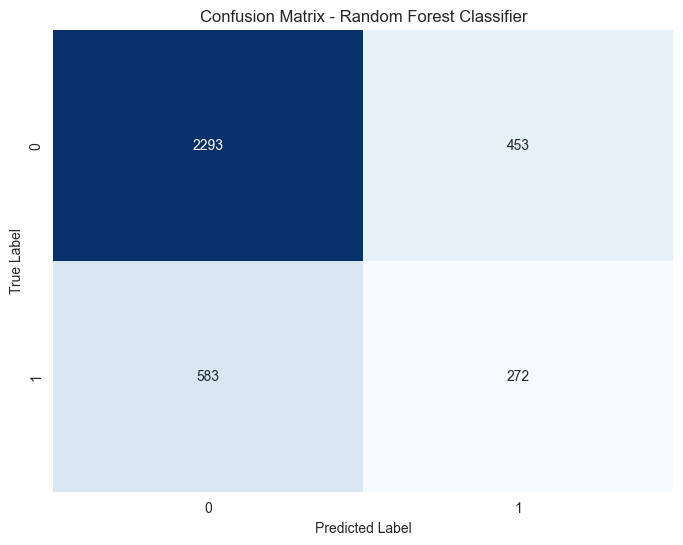

Classification Report - Random Forest Classifier:
               precision    recall  f1-score   support

          NO       0.80      0.84      0.82      2746
         YES       0.38      0.32      0.34       855

    accuracy                           0.71      3601
   macro avg       0.59      0.58      0.58      3601
weighted avg       0.70      0.71      0.70      3601



In [159]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", accuracy_rf)

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate classification report
class_report_rf = classification_report(y_test, y_pred_rf)

# Print classification report
print("Classification Report - Random Forest Classifier:\n", class_report_rf)

### 2. Support Vector Machine

In [160]:
from sklearn.svm import SVC

# Select variables
X = df.drop(columns=['date', 'time', 'alerta_crecida'])
y = df['alerta_crecida']

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine (SVM) Classifier Accuracy:", accuracy_svm)

# Print classification report
print("Classification Report - Support Vector Machine (SVM) Classifier:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM) Classifier Accuracy: 0.762565953901694
Classification Report - Support Vector Machine (SVM) Classifier:
              precision    recall  f1-score   support

          NO       0.76      1.00      0.87      2746
         YES       0.00      0.00      0.00       855

    accuracy                           0.76      3601
   macro avg       0.38      0.50      0.43      3601
weighted avg       0.58      0.76      0.66      3601



/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3. Gradient Boosting Machine

Gradient Boosting Classifier Accuracy: 0.7672868647597889
Classification Report - Gradient Boosting Classifier:
              precision    recall  f1-score   support

          NO       0.77      1.00      0.87      2746
         YES       0.72      0.03      0.06       855

    accuracy                           0.77      3601
   macro avg       0.74      0.51      0.46      3601
weighted avg       0.76      0.77      0.68      3601



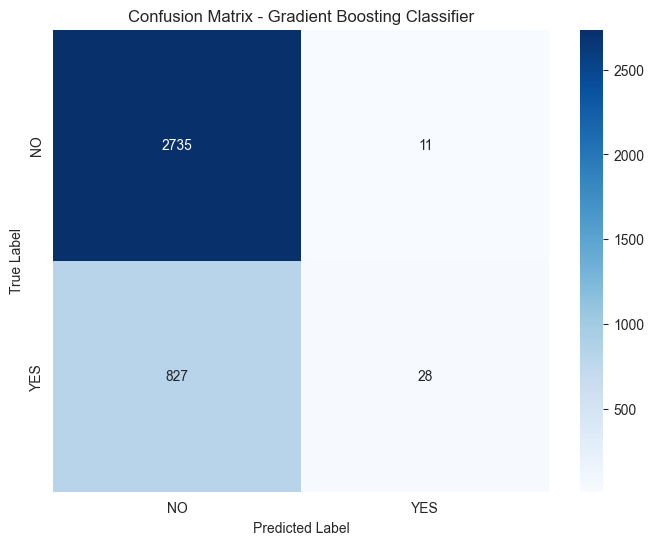

In [161]:
from sklearn.ensemble import GradientBoostingClassifier

# Select variables
X = df.drop(columns=['date', 'time', 'alerta_crecida'])
y = df['alerta_crecida']

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the Gradient Boosting classifier
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_classifier.predict(X_test)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Classifier Accuracy:", accuracy_gb)

# Print classification report
print("Classification Report - Gradient Boosting Classifier:")
print(classification_report(y_test, y_pred_gb))

# Calculate confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Blues", 
            xticklabels=gb_classifier.classes_, yticklabels=gb_classifier.classes_)
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 4. Ensamble Method

Ensemble Classifier Accuracy: 0.762565953901694
Classification Report - Ensemble Classifier:
              precision    recall  f1-score   support

          NO       0.76      1.00      0.87      2746
         YES       0.00      0.00      0.00       855

    accuracy                           0.76      3601
   macro avg       0.38      0.50      0.43      3601
weighted avg       0.58      0.76      0.66      3601



/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


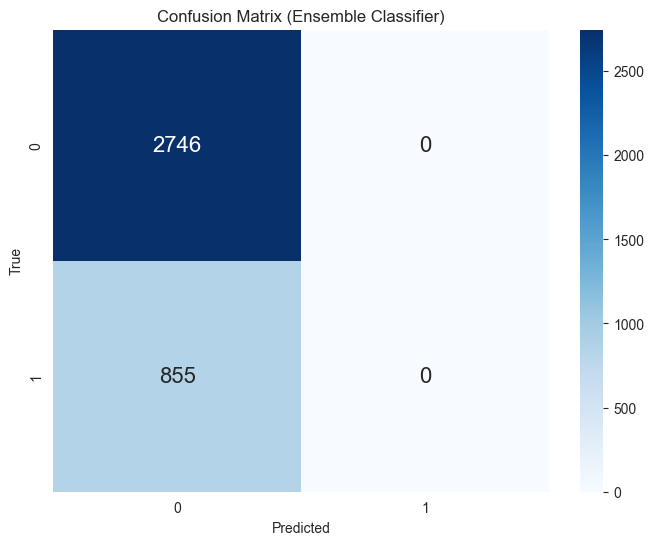

In [162]:
from sklearn.ensemble import VotingClassifier

# Select variables
X = df.drop(columns=['date', 'time', 'alerta_crecida'])
y = df['alerta_crecida']

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
svc = SVC()
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create ensemble classifier
ensemble_classifier = VotingClassifier(estimators=[
    ('lr', logistic_regression),
    ('rf', random_forest),
    ('svc', svc),
    ('gb', gradient_boosting)
], voting='hard')

# Train ensemble classifier
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ensemble = ensemble_classifier.predict(X_test)

# Calculate accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Ensemble Classifier Accuracy:", accuracy_ensemble)

# Print classification report
print("Classification Report - Ensemble Classifier:")
print(classification_report(y_test, y_pred_ensemble))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix (Ensemble Classifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 5. Balanced Random Forest

/Users/axelcasas/miniconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt th

Balanced Random Forest Classifier Accuracy: 0.6242710358233824
Classification Report - Balanced Random Forest Classifier:
              precision    recall  f1-score   support

          NO       0.84      0.62      0.72      2746
         YES       0.34      0.63      0.44       855

    accuracy                           0.62      3601
   macro avg       0.59      0.63      0.58      3601
weighted avg       0.73      0.62      0.65      3601



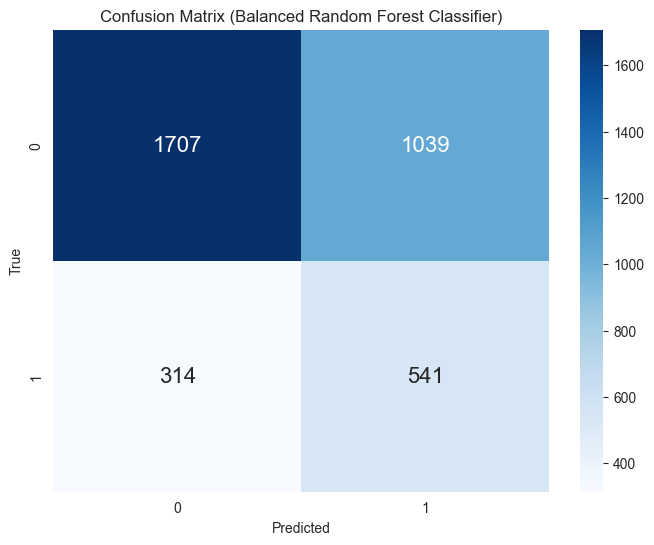

In [163]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Select variables
X = df.drop(columns=['date', 'time', 'alerta_crecida'])
y = df['alerta_crecida']

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Balanced Random Forest classifier
balanced_rf_classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
balanced_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_balanced_rf = balanced_rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_balanced_rf = accuracy_score(y_test, y_pred_balanced_rf)
print("Balanced Random Forest Classifier Accuracy:", accuracy_balanced_rf)

# Print classification report
print("Classification Report - Balanced Random Forest Classifier:")
print(classification_report(y_test, y_pred_balanced_rf))

# Calculate confusion matrix
cm_balanced_rf = confusion_matrix(y_test, y_pred_balanced_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced_rf, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix (Balanced Random Forest Classifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### 6. Catboost

Classification Report - CatBoost Classifier:
              precision    recall  f1-score   support

          NO       0.77      1.00      0.87      2746
         YES       0.72      0.02      0.05       855

    accuracy                           0.77      3601
   macro avg       0.75      0.51      0.46      3601
weighted avg       0.76      0.77      0.67      3601



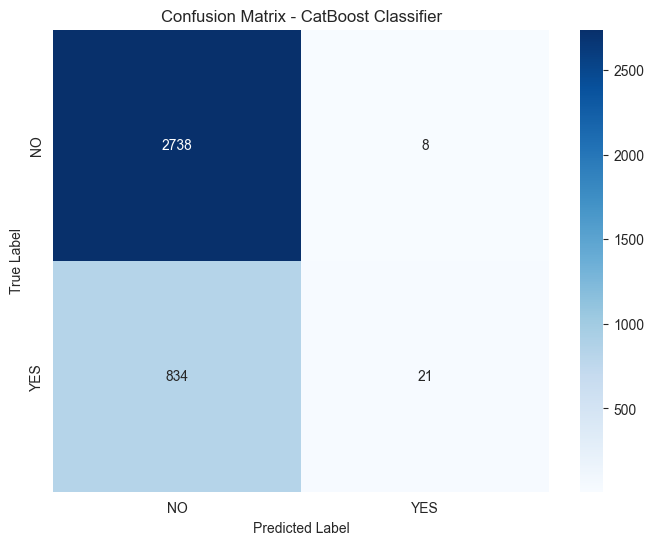

In [164]:
from catboost import CatBoostClassifier

# Define feature matrix X and target vector y
X = df.drop(columns=['date', 'time', 'alerta_crecida'])
y = df['alerta_crecida']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost classifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42)
catboost_model.fit(X_train, y_train, verbose=False)

# Make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test)

# Visualize the classification report
print("Classification Report - CatBoost Classifier:")
print(classification_report(y_test, y_pred_catboost))

# Calculate confusion matrix
conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", 
            xticklabels=catboost_model.classes_, yticklabels=catboost_model.classes_)
plt.title('Confusion Matrix - CatBoost Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()